In [7]:
import sys
import os

# Add the project root to the search path
sys.path.append(os.path.abspath(".."))

# Import from src
from src import *


In [259]:
def rounding_87(Y, N, instance, h_planes=1000):
    """
    Generates random solutions to a Max-2-SAT problem using hyperplane rounding on the SDP solution.

    Args:
        Y (ndarray): The solution matrix from the SDP relaxation of the Max-2-SAT problem.
        N (int): Number of variables in the Max-2-SAT problem.
        instance (ndarray): A 2D array where each row represents a clause as two literals 
                             (e.g., [[1, -2], [-3, 4]]). The literals can be positive or negative 
                             integers representing variable indices.
        h_planes (int, optional): Number of hyperplanes used for rounding. Default is 10000.

    Returns:
        list: A list containing the number of violated clauses (NVC) for each random solution generated.

    Methodology:
        1. Use the solution matrix `Y` obtained from SDP relaxation.
        2. Perform hyperplane rounding: 
           - Generate random vectors and project the SDP solution to produce ±1 solutions.
        3. Count the number of violated clauses for each random solution using the `violated_clauses` function.
    """
    # Initialize list for storing number of violated clauses
    NVC = []
    N_round = h_planes

    # Perform hyperplane rounding and evaluate solutions
    for _ in range(N_round):
        u = np.random.randn(N + 1)  # Normal vector for a random hyperplane
        eigenvalues, eigenvectors = np.linalg.eigh(Y)
        # Compute the square root
        Sqrt_y = eigenvectors @ np.diag(np.sqrt(np.maximum(eigenvalues, 0))) @ eigenvectors.T
        x = np.sign(Sqrt_y @ u)
        solution = x[0] * x[1:]     # Extract solution in ±1 format
        nvc = violated_clauses(instance, solution)  # Count violated clauses
        NVC.append(nvc)
        
    return NVC

In [260]:
import numpy as np

# Rotation function (from the paper)
def rotation_function(theta):
    return 0.58831458 * theta + 0.64667394

# Step 1: Decompose SDP Matrix
def decompose_sdp(Y):
    eigenvalues, eigenvectors = np.linalg.eigh(Y)
    S = eigenvectors @ np.diag(np.sqrt(np.maximum(eigenvalues, 0))) @ eigenvectors.T
    return S

# Step 2: Generate Skewed Hyperplane
def generate_skewed_hyperplane(v0, r0=2):
    r_perp = np.random.randn(len(v0))
    r_perp -= (np.dot(r_perp, v0) / np.dot(v0, v0)) * v0  # Orthogonalize to v0
    r_perp /= np.linalg.norm(r_perp)                     # Normalize

    r = r0 * v0 + r_perp  # Add the skew using r0
    return r

# Step 3: Rotate Vectors
def rotate_vector(v0, vi, Y_0i):
    theta_i = np.arccos(np.clip(Y_0i, -1.0, 1.0))
    theta_i_prime = rotation_function(theta_i)

    vi_proj = vi - np.dot(v0, vi) * v0
    if np.linalg.norm(vi_proj) == 0:
        return v0
    vi_rot = np.cos(theta_i_prime) * v0 + np.sin(theta_i_prime) * (vi_proj / np.linalg.norm(vi_proj))
    return vi_rot

# Step 4: Assignment Using the Skewed Hyperplane
def assign_variable(v0, vi_rot, r):
    return 1 if np.sign(np.dot(v0, r)) != np.sign(np.dot(vi_rot, r)) else -1

def sample_r0():
    # Define the probabilities and values
    probabilities = [0.0430, 0.0209, 0.0747, 0.3448, 0.5166]
    values = [None, 0.145, 0.345, 0.755, 1.635]  # None represents the normal distribution

    # Choose the distribution based on the probabilities
    choice = np.random.choice(values, p=probabilities)

    # Sample from the chosen distribution
    if choice is None:
        # Sample from the normal distribution
        r0 = np.random.normal()
    else:
        # Use the chosen value
        r0 = choice
    return r0

# Step 5: Complete Rounding Procedure
def improved_rounding(Y, N, instance, h_planes=10000):
    NVC = []               # Number of Violated Clauses (results storage)
    Solution = []          # Solution storage
    # r0 = 2                 # Skew parameter (bias)
    S = decompose_sdp(Y)   # Decompose SDP solution
    v0 = S[:, 0]           # Reference vector

    for _ in range(h_planes):
        r0 = sample_r0()
        r = generate_skewed_hyperplane(v0, r0)  # Skewed hyperplane
        # solution = np.zeros(N, dtype=int)

        # for i in range(1, N + 1):
        #     vi = S[:, i]
        #     # vi_rot = rotate_vector(v0, vi, Y[0, i])  # Rotate vectors
        #     # solution[i - 1] = v0 * vi
        #     vi_rot = vi
        #     solution[i - 1] = assign_variable(v0, vi_rot, r)  # Assign literals
        
        x = np.sign(S @ r)
        solution = x[0] * x[1:]     # Extract solution in ±1 format
        
        nvc = violated_clauses(instance, solution)  # Count violated clauses
        NVC.append(nvc)
        Solution.append(solution)

    return NVC, Solution

def generate_random_hyperplane(dim):
    r = np.random.randn(dim)  # Standard Gaussian vector
    r /= np.linalg.norm(r)    # Normalize to unit vector (optional)
    return r

def goemans_williamson_rounding(Y, N, instance, h_planes=10000):
    NVC = []  # Store number of violated clauses for each rounding
    S = decompose_sdp(Y)
    v0 = S[:, 0]  # Reference vector representing `False`

    for _ in range(h_planes):
        r = generate_random_hyperplane(S.shape[0])  # Random hyperplane
        solution = np.zeros(N, dtype=int)

        for i in range(1, N + 1):
            vi = S[:, i]
            # Assign based on the sign of the dot product
            solution[i - 1] = 1 if np.sign(np.dot(v0, r)) == np.sign(np.dot(vi, r)) else -1

        nvc = violated_clauses(instance, solution)  # Count violated clauses
        NVC.append(nvc)

    return NVC





In [261]:
S = decompose_sdp(Y)   # Decompose SDP solution
v0 = S[:, 0]
generate_skewed_hyperplane(v0, 2)

array([ 5.89943954e-01,  2.30115877e-01,  2.63066444e-01, -2.11838793e-01,
        2.54111316e-01, -1.28411190e-04,  1.37277584e-01,  4.90056348e-01,
       -3.62640115e-01, -1.07240574e-01, -2.03994282e-01,  1.51271517e-01,
       -2.18118263e-01, -2.15976995e-01,  1.98826956e-01, -3.85869150e-01,
        1.97726615e-01, -1.97261660e-01,  3.63868330e-01, -4.23777262e-02,
       -5.90382125e-02, -1.45071002e-01, -7.42857842e-03,  8.24366468e-02,
       -3.37512084e-01, -4.27050158e-01, -1.48729706e-01, -1.96874289e-01,
       -4.41576504e-01,  6.86935695e-02, -3.21219674e-02, -1.52342423e-01,
       -6.06713900e-01, -6.12863371e-01,  2.73728765e-02, -2.88139306e-01,
       -4.43838011e-01, -1.96879047e-01,  3.34408925e-01,  1.42693312e-01,
       -1.72156213e-01,  3.85899432e-01, -2.67306425e-01, -2.16534054e-01,
       -5.08017332e-01, -3.35769944e-01,  2.32835706e-01, -4.97805584e-01,
        3.19204865e-01,  4.17033253e-01,  6.36815530e-01])

In [262]:
# Generate random max-2SAT instance

N = 10    # number of variables
M = N*3   # number of clauses

instance = generate_max_2_sat(N, M)

# Get the exact solution using rc2 solver

sol, sol_nvc = rc2_solver(N, instance)
print("Solution :", sol)
print("Number of violated clauses:", sol_nvc)

# using SDP on the instance

Y =SDP_max_sat(N, instance, "Mosek")

# rounding the SDP solution

NVC = rounding_87(Y, N, instance, 10000)

print("Average approx ratio :",(M-np.mean(NVC))/(M-sol_nvc))
print("Best approx ratio    :",(M-np.min(NVC))/(M-sol_nvc))
print("Worst approx ratio   :",(M-np.max(NVC))/(M-sol_nvc))


r0 = 2
NVC, Solution = improved_rounding(Y, N, instance)
print(" ")
print("Average approx ratio :",(M-np.mean(NVC))/(M-sol_nvc))
print("Best approx ratio    :",(M-np.min(NVC))/(M-sol_nvc))
print("Worst approx ratio   :",(M-np.max(NVC))/(M-sol_nvc))

NVC = goemans_williamson_rounding(Y, N, instance)
print(" ")
print("Average approx ratio :",(M-np.mean(NVC))/(M-sol_nvc))
print("Best approx ratio    :",(M-np.min(NVC))/(M-sol_nvc))
print("Worst approx ratio   :",(M-np.max(NVC))/(M-sol_nvc))


Solution : [ 1 -1  1 -1  1 -1  1  1  1 -1]
Number of violated clauses: 3
Average approx ratio : 0.983725925925926
Best approx ratio    : 1.0
Worst approx ratio   : 0.9259259259259259
 
Average approx ratio : 0.9983111111111111
Best approx ratio    : 1.0
Worst approx ratio   : 0.9259259259259259
 
Average approx ratio : 0.9845666666666667
Best approx ratio    : 1.0
Worst approx ratio   : 0.9259259259259259


In [263]:
S = decompose_sdp(Y)   # Decompose SDP solution
v0 = S[:, 0]
v0
r = generate_skewed_hyperplane(v0, r0)
x = np.sign(S @ r)
x

array([ 1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.])

In [264]:
np.shape(r)

(11,)

In [265]:
import numpy as np

def sample_r0():
    # Define the probabilities and values
    probabilities = [0.0430, 0.0209, 0.0747, 0.3448, 0.5166]
    values = [None, 0.145, 0.345, 0.755, 1.635]  # None represents the normal distribution

    # Choose the distribution based on the probabilities
    choice = np.random.choice(values, p=probabilities)

    # Sample from the chosen distribution
    if choice is None:
        # Sample from the normal distribution
        r0 = np.random.normal()
    else:
        # Use the chosen value
        r0 = choice
    return r0


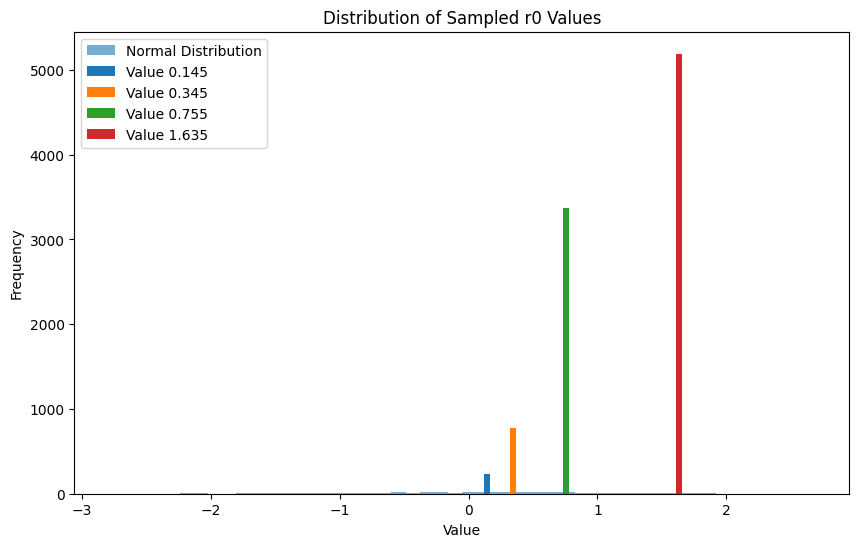

In [266]:
import matplotlib.pyplot as plt
from collections import Counter

# Generate a large number of samples
num_samples = 10000
samples = [sample_r0() for _ in range(num_samples)]

# Count the occurrences of each value
counter = Counter(samples)

# Separate the normal distribution samples from the fixed values
normal_samples = [x for x in samples if x not in [0.145, 0.345, 0.755, 1.635]]
fixed_values = [0.145, 0.345, 0.755, 1.635]

# Plot the distribution
plt.figure(figsize=(10, 6))

# Plot the histogram for the normal distribution samples
plt.hist(normal_samples, bins=50, alpha=0.6, label='Normal Distribution')

# Plot the bar chart for the fixed values
for value in fixed_values:
    plt.bar(value, counter[value], width=0.05, label=f'Value {value}')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Sampled r0 Values')
plt.legend()
plt.show()

In [2]:
from src.Max2sat import violated_clauses

import cvxpy as cp
import numpy as np

 

def SDP_max_sat_og(N, instance, solver="default"):
    """
    Solves a Max-2-SAT problem using a semidefinite programming (SDP) relaxation

    Args:
        N (int): Number of variables in the Max-2-SAT problem.
        instance (ndarray): A 2D array where each row represents a clause as two literals 
                             (e.g., [[1, -2], [-3, 4]]). The literals can be positive or negative 
                             integers representing variable indices.
        solver (str, optional): The solver to use for solving the SDP. Options are 'Default' or 'Mosek'.
                                 Default is 'Default'.

    Returns:
        ndarray: The solution matrix `Y`, representing the relaxed SDP solution.

    Methodology:
        1. Construct a semidefinite programming relaxation for the Max-2-SAT problem:
           - Introduce a positive semidefinite (PSD) variable matrix `Y`.
           - Define the objective function based on SDP relaxation terms involving the clauses.
           - Add diagonal constraints to enforce vector normalization.
        2. Solve the SDP problem using the chosen solver.

    """
    # Define SDP variable
    Y = cp.Variable((N + 1, N + 1), PSD=True)

    # Extract clause weights and variable indices
    weights = np.sign(instance)
    variables = np.abs(instance)

    indices_0 = variables[:, 0]  # First variable in each clause
    indices_1 = variables[:, 1]  # Second variable in each clause
    w0 = weights[:, 0].reshape(1, -1)  # Weights for the first variables
    w1 = weights[:, 1].reshape(1, -1)  # Weights for the second variables

    # Precompute indexed slices for Y
    Y_0_indices_0 = cp.vstack([Y[0, i] for i in indices_0]).T
    Y_0_indices_1 = cp.vstack([Y[0, i] for i in indices_1]).T
    Y_indices_0_1 = cp.vstack([Y[i, j] for i, j in zip(indices_0, indices_1)]).T

    # Precompute w0 * w1
    w0_w1 = np.multiply(w0, w1)

    # Define constraints for Y
    constraints = [cp.diag(Y) == 1]

    # Fix the reference vector by forcing nonnegative inner products
    # for i in range(1, N + 1):
    #     constraints.append(Y[0, i] >= 0)


    # Define the objective function for SDP relaxation
    terms = (1 / 4) * (
        3
        + cp.multiply(w0, Y_0_indices_0)
        + cp.multiply(w1, Y_0_indices_1)
        - cp.multiply(w0_w1, Y_indices_0_1)
    )
    objective = cp.sum(terms)

    # Solve the SDP problem
    prob = cp.Problem(cp.Maximize(objective), constraints)
    if solver == "default":
        prob.solve()
    elif solver == "Mosek":
        prob.solve(solver=cp.MOSEK)  # Use MOSEK solver

    return Y.value

In [3]:
import cvxpy as cp
import numpy as np

def SDP_max_sat(N, instance, solver="default"):
    """
    Solves a Max-2-SAT problem using a semidefinite programming (SDP) relaxation.

    Args:
        N (int): Number of variables in the Max-2-SAT problem.
        instance (array-like): A 2D array where each row represents a clause as two literals 
                               (e.g., [[1, -2], [-3, 4]]). Literals are given as positive or negative integers.
        solver (str, optional): The solver to use for solving the SDP ("default" or "Mosek").
                                Default is "default".

    Returns:
        numpy.ndarray: The solution matrix Y representing the relaxed SDP solution.
    """
    # Convert instance to a NumPy array.
    instance = np.asarray(instance)
    
    # Compute sign weights and variable indices.
    weights = np.sign(instance)
    variables = np.abs(instance).astype(int)
    
    # Extract indices for the first and second literals.
    indices_0 = variables[:, 0]
    indices_1 = variables[:, 1]
    
    # Extract weights and reshape to (1, num_clauses) for broadcasting.
    w0 = weights[:, 0].reshape(1, -1)
    w1 = weights[:, 1].reshape(1, -1)
    w0w1 = (w0 * w1).reshape(1, -1)
    
    # Wrap weights as CVXPY constants.
    w0_const = cp.Constant(w0)
    w1_const = cp.Constant(w1)
    w0w1_const = cp.Constant(w0w1)
    
    # Define SDP variable: (N+1) x (N+1) PSD matrix.
    Y = cp.Variable((N + 1, N + 1), PSD=True)
    
    # Try to use advanced indexing for efficiency.
    try:
        Y0_i = cp.reshape(Y[0, indices_0], (1, -1))
        Y0_j = cp.reshape(Y[0, indices_1], (1, -1))
        # For each clause, extract Y[i,j] with i and j from indices_0 and indices_1.
        Yij = cp.hstack([Y[i, j] for i, j in zip(indices_0, indices_1)])
        Yij = cp.reshape(Yij, (1, -1))  # reshape to (1, num_clauses)
    except Exception:
        # Fallback: use list comprehension.
        Y0_i = cp.hstack([Y[0, i] for i in indices_0])
        Y0_j = cp.hstack([Y[0, j] for j in indices_1])
        Yij = cp.hstack([Y[i, j] for i, j in zip(indices_0, indices_1)])
        Yij = cp.reshape(Yij, (1, -1))
    
    # Diagonal constraints enforce unit norm on each vector (including the reference vector).
    constraints = [cp.diag(Y) == 1]
    
    # Define the objective function.
    # For each clause, term = (1/4)*(3 + w0*Y[0,i] + w1*Y[0,j] - (w0*w1)*Y[i,j])
    terms = (1/4) * (3 + cp.multiply(w0_const, Y0_i)
                        + cp.multiply(w1_const, Y0_j)
                        - cp.multiply(w0w1_const, Yij))
    objective = cp.sum(terms)
    
    # Set up and solve the problem.
    prob = cp.Problem(cp.Maximize(objective), constraints)
    
    if solver.lower() == "mosek":
        prob.solve(solver=cp.MOSEK)
    else:
        prob.solve()
    
    return Y.value


In [8]:
import numpy as np
import timeit
import memory_profiler

# Generate test instances
N = 200  # Number of variables
M = N*3  # Number of clauses
instance = generate_max_2_sat(N, M)  # Generate test clauses

# Number of trials for benchmarking
num_trials = 1

# Measure Execution Time Using timeit
original_time = timeit.timeit(lambda: SDP_max_sat_og(N, instance, solver="Mosek"), number=num_trials) / num_trials
fixed_time = timeit.timeit(lambda: SDP_max_sat(N, instance, solver="Mosek"), number=num_trials) / num_trials

# Measure Memory Usage Using memory_profiler
# original_memory = memory_profiler.memory_usage((SDP_max_sat_og, (N, instance, "Mosek")), max_usage=True)
# fixed_memory = memory_profiler.memory_usage((SDP_max_sat, (N, instance, "Mosek")), max_usage=True)

# Run Once to Compare Outputs
# Y_original = SDP_max_sat_og(N, instance, solver="Mosek")
# Y_fixed = SDP_max_sat(N, instance, solver="Mosek")

# Compute Output Difference
# difference = np.linalg.norm(Y_original - Y_fixed)  # Frobenius norm difference

# Print Results
print("=" * 60)
print(f"Benchmarking Results (N={N}, M={M}, Trials={num_trials})")
print("=" * 60)
print(f"Original Code Average Runtime: {original_time:.4f} seconds")
print(f"Fixed Code Average Runtime   : {fixed_time:.4f} seconds")
print("-" * 60)
# print(f"Original Code Max Memory Usage: {original_memory:.2f} MB")
# print(f"Fixed Code Max Memory Usage   : {fixed_memory:.2f} MB")
# print("-" * 60)
# print(f"Output Difference (Frobenius Norm): {difference:.6f}")
# print("=" * 60)

# Efficiency Conclusion
# if np.allclose(Y_original, Y_fixed, atol=1e-4):
#     print("✅ The fixed code produces nearly identical results to the original.")
# else:
#     print("⚠️ The fixed code produces different results from the original.")


Benchmarking Results (N=200, M=600, Trials=1)
Original Code Average Runtime: 142.3817 seconds
Fixed Code Average Runtime   : 141.9860 seconds
------------------------------------------------------------


In [4]:
import numpy as np
import timeit
import memory_profiler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# -------------------------
# Benchmarking parameters
N_values = [200]           # List of different numbers of variables.
alpha_values = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]  # alpha = M/N.
num_trials = 1                      # Number of trials per (N, alpha) combination.

results = []  # To store (N, alpha, M, avg_time, max_memory)

print("Benchmarking SDP_max_sat over different N and alpha values:")
for N in N_values:
    for alpha in alpha_values:
        M = int(alpha * N)
        instance = generate_max_2_sat(N, M)
        
        # Measure average runtime using timeit.
        avg_time = timeit.timeit(lambda: SDP_max_sat(N, instance, solver="Mosek"),
                                 number=num_trials) / num_trials
        
        # Measure maximum memory usage (in MB) using memory_profiler.
        # max_memory = memory_profiler.memory_usage((SDP_max_sat, (N, instance, "Mosek")), max_usage=True)
        
        # results.append((N, alpha, M, avg_time, max_memory))
        # print(f"N={N}, alpha={alpha}, M={M}: time={avg_time:.4f} s, memory={max_memory:.2f} MB")
        results.append((N, alpha, M, avg_time))
        print(f"N={N}, alpha={alpha}, M={M}: time={avg_time:.4f} s")

# Convert results to a NumPy array.
results = np.array(results, dtype=object)

# -------------------------
# Prepare features and target for regression.
# We'll use N and M as features; runtime is the target.
X = np.array([[row[0], row[2]] for row in results])  # Feature matrix: columns are [N, M]
y = np.array([row[3] for row in results])             # Target vector: average runtime


Benchmarking SDP_max_sat over different N and alpha values:
N=200, alpha=1.0, M=200: time=126.4393 s
N=200, alpha=2.0, M=400: time=126.5996 s
N=200, alpha=3.0, M=600: time=143.7269 s
N=200, alpha=4.0, M=800: time=127.5432 s
N=200, alpha=5.0, M=1000: time=146.7510 s
N=200, alpha=6.0, M=1200: time=145.3392 s


In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error

# -----------------------------------------------------------------------------
# Fixed prediction parameters.
N_new = 200             # Fixed number of variables.
alpha_new = 3.0         # Density parameter.
M_new = int(alpha_new * N_new)
X_new = np.array([[N_new, M_new]])

# Number of instances per alpha value.
instances_per_alpha = 50

# Define the range of alpha values (from 0.8 to 6.0, step 0.2).
alpha_range = np.arange(0.8, 6.0 + 0.2, 0.2)

# -----------------------------------------------------------------------------
# Define multiple regression models.
models = {
    'LinearRegression': LinearRegression(),
    'PolynomialRegression': Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ]),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=1e3, gamma=0.1),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'KernelRidge': KernelRidge(alpha=1.0, kernel='rbf')
}

print("Fitting various regression models and predicting runtime for N=%d, alpha=%.1f (M=%d):" 
      % (N_new, alpha_new, M_new))

# -----------------------------------------------------------------------------
# Train each model, report prediction and training MSE, then compute total predicted runtime.
for model_name, model in models.items():
    # Fit the model on benchmark data.
    model.fit(X, y)
    
    # Predict runtime for the fixed instance.
    prediction = model.predict(X_new)[0]
    mse = mean_squared_error(y, model.predict(X))
    
    print(f"\n{model_name}:")
    print(f"  Prediction for N={N_new}, alpha={alpha_new} (M={M_new}): {prediction:.4f} seconds")
    print(f"  Training MSE: {mse:.4f}")
    
    # Calculate total predicted runtime over the alpha range.
    total_time = 0.0
    for alpha in alpha_range:
        M_val = int(alpha * N_new)
        X_alpha = np.array([[N_new, M_val]])
        predicted_time = model.predict(X_alpha)[0]
        total_time += predicted_time * instances_per_alpha

    # Convert total time (in seconds) to hours, minutes, and seconds.
    hours = int(total_time // 3600)
    minutes = int((total_time % 3600) // 60)
    seconds = total_time % 60

    print(f"  Total predicted runtime (50 instances per alpha, α ∈ [{alpha_range[0]:.1f}, {alpha_range[-1]:.1f}]):")
    print(f"     {total_time:.4f} seconds  -->  {hours} hours, {minutes} minutes, {seconds:.2f} seconds")


Fitting various regression models and predicting runtime for N=200, alpha=3.0 (M=600):

LinearRegression:
  Prediction for N=200, alpha=3.0 (M=600): 134.0841 seconds
  Training MSE: 39.7789
  Total predicted runtime (50 instances per alpha, α ∈ [0.8, 6.0]):
     183133.7257 seconds  -->  50 hours, 52 minutes, 13.73 seconds

PolynomialRegression:
  Prediction for N=200, alpha=3.0 (M=600): 134.0621 seconds
  Training MSE: 39.7785
  Total predicted runtime (50 instances per alpha, α ∈ [0.8, 6.0]):
     183128.3426 seconds  -->  50 hours, 52 minutes, 8.34 seconds



RandomForestRegressor:
  Prediction for N=200, alpha=3.0 (M=600): 137.5956 seconds
  Training MSE: 16.0269
  Total predicted runtime (50 instances per alpha, α ∈ [0.8, 6.0]):
     183486.3173 seconds  -->  50 hours, 58 minutes, 6.32 seconds

SVR:
  Prediction for N=200, alpha=3.0 (M=600): 143.6267 seconds
  Training MSE: 0.0100
  Total predicted runtime (50 instances per alpha, α ∈ [0.8, 6.0]):
     183644.4684 seconds  -->  51 hours, 0 minutes, 44.47 seconds

MLPRegressor:
  Prediction for N=200, alpha=3.0 (M=600): 143.7187 seconds
  Training MSE: 0.6446
  Total predicted runtime (50 instances per alpha, α ∈ [0.8, 6.0]):
     182831.7828 seconds  -->  50 hours, 47 minutes, 11.78 seconds

GradientBoostingRegressor:
  Prediction for N=200, alpha=3.0 (M=600): 143.7267 seconds
  Training MSE: 0.0000
  Total predicted runtime (50 instances per alpha, α ∈ [0.8, 6.0]):
     183243.9014 seconds  -->  50 hours, 54 minutes, 3.90 seconds

KernelRidge:
  Prediction for N=200, alpha=3.0 (M=600): 

In [10]:



def rounding_87(Y, N, instance, h_planes=1000):
    """
    Perform 0.87 Random Hyperplane Rounding on the SDP solution matrix Y.

    Parameters:
    Y (numpy.ndarray): The solution matrix obtained from SDP relaxation.
    N (int): The number of variables.
    instance (list): The MAX-2SAT instance.
    h_planes (int): The number of random hyperplanes to use for rounding.

    Returns:
    list: A list containing the number of violated clauses for each random solution.
    """
    # Decompose Y once
    eigenvalues, eigenvectors = np.linalg.eigh(Y)
    Sqrt_y = eigenvectors @ np.diag(np.sqrt(np.maximum(eigenvalues, 0))) @ eigenvectors.T
    
    NVC = []
    for _ in range(h_planes):
        u = np.random.randn(N + 1)
        x = np.sign(Sqrt_y @ u)
        solution = x[0] * x[1:]
        nvc = violated_clauses(instance, solution)
        NVC.append(nvc)
    
    return NVC


import numpy as np

# Decompose the SDP Matrix
def decompose_sdp(Y):
    """
    Decompose the SDP matrix Y into its square root form.

    Parameters:
    Y (numpy.ndarray): The SDP matrix.

    Returns:
    numpy.ndarray: The square root of the SDP matrix.
    """
    eigenvalues, eigenvectors = np.linalg.eigh(Y)
    S = eigenvectors @ np.diag(np.sqrt(np.maximum(eigenvalues, 0))) @ eigenvectors.T
    return S

# Basic Rotation Function (from the paper)
def rotation_function(theta):
    """
    Basic rotation function from the paper.

    Parameters:
    theta (float): The angle in radians.

    Returns:
    float: The rotated angle.
    """
    return 0.58831458 * theta + 0.64667394

# Rotate a Vector (used in ROT and ROT+SKEW)
def rotate_vector(v0, vi):
    # Normalize
    norm_v0 = np.linalg.norm(v0)
    norm_vi = np.linalg.norm(vi)
    if norm_v0 == 0 or norm_vi == 0:
        # Degenerate: just return something consistent
        return v0
    
    cos_angle = np.dot(v0, vi) / (norm_v0 * norm_vi)
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    theta_i = np.arccos(cos_angle)

    # Then apply your custom rotation_function
    theta_i_prime = rotation_function(theta_i)
    
    # Now rotate in the plane spanned by v0 and vi
    # project vi to plane orthogonal to v0:
    v0_u = v0 / norm_v0
    vi_proj = vi - np.dot(vi, v0_u) * v0_u
    norm_proj = np.linalg.norm(vi_proj)
    if norm_proj == 0:
        return v0  # or v0_u, whichever your logic requires
    
    vi_dir = vi_proj / norm_proj
    vi_rot = np.cos(theta_i_prime) * v0_u + np.sin(theta_i_prime) * vi_dir
    vi_rot /= np.linalg.norm(vi_rot)  # Ensure unit norm
    return vi_rot



def gw_rounding(Y, N, instance, h_planes=1000):
    """
    Perform Goemans-Williamson (G&W) Random Hyperplane Rounding on the SDP solution matrix Y.

    Parameters:
    Y (numpy.ndarray): The solution matrix obtained from SDP relaxation.
    N (int): The number of variables.
    instance (list): The MAX-2SAT instance.
    h_planes (int): The number of random hyperplanes to use for rounding.

    Returns:
    list: A list containing the number of violated clauses for each random solution.
    """
    NVC = []
    S = decompose_sdp(Y)
    v0 = S[:, 0]

    for _ in range(h_planes):
        r = np.random.randn(S.shape[0])  # Random hyperplane
        r /= np.linalg.norm(r)
        
        solution = np.array([1 if np.sign(np.dot(v0, r)) == np.sign(np.dot(S[:, i], r)) else -1 for i in range(1, N + 1)])
        nvc = violated_clauses(instance, solution)
        NVC.append(nvc)

    return NVC

def rot_rounding(Y, N, instance, h_planes=1000):
    """
    Perform Rotation-Based Rounding on the SDP solution matrix Y.

    Parameters:
    Y (numpy.ndarray): The solution matrix obtained from SDP relaxation.
    N (int): The number of variables.
    instance (list): The MAX-2SAT instance.
    h_planes (int): The number of random hyperplanes to use for rounding.

    Returns:
    list: A list containing the number of violated clauses for each random solution.
    """
    NVC = []
    S = decompose_sdp(Y)
    v0 = S[:, 0]

    for _ in range(h_planes):
        r = np.random.randn(S.shape[0])
        r /= np.linalg.norm(r)

        solution = []
        for i in range(1, N + 1):
            vi_rot = rotate_vector(v0, S[:, i])
            solution.append(1 if np.sign(np.dot(v0, r)) == np.sign(np.dot(vi_rot, r)) else -1)
        
        nvc = violated_clauses(instance, np.array(solution))
        NVC.append(nvc)

    return NVC



def generate_skewed_hyperplane(v0, r0=2):
    r_perp = np.random.randn(len(v0))
    r_perp -= (np.dot(r_perp, v0) / np.dot(v0, v0)) * v0
    r_perp /= np.linalg.norm(r_perp)
    return r0 * v0 + r_perp  # Apply skew

def sample_r0():
    # Define the probabilities and values
    probabilities = [0.0430, 0.0209, 0.0747, 0.3448, 0.5166]
    values = [None, 0.145, 0.345, 0.755, 1.635]  # None represents the normal distribution

    # Choose the distribution based on the probabilities
    choice = np.random.choice(values, p=probabilities)

    # Sample from the chosen distribution
    if choice is None:
        # Sample from the normal distribution
        r0 = np.random.normal()
    else:
        # Use the chosen value
        r0 = choice
    return r0

def skew_rounding(Y, N, instance, h_planes=1000):
    """
    Perform Skewed Hyperplane Rounding on the SDP solution matrix Y.

    Parameters:
    Y (numpy.ndarray): The solution matrix obtained from SDP relaxation.
    N (int): The number of variables.
    instance (list): The MAX-2SAT instance.
    h_planes (int): The number of random hyperplanes to use for rounding.

    Returns:
    list: A list containing the number of violated clauses for each random solution.
    """
    NVC = []
    S = decompose_sdp(Y)
    v0 = S[:, 0]
    r0 = sample_r0()  # Fixed bias from the paper

    for _ in range(h_planes):
        r = generate_skewed_hyperplane(v0, r0)

        solution = np.array([1 if np.sign(np.dot(v0, r)) == np.sign(np.dot(S[:, i], r)) else -1 for i in range(1, N + 1)])
        nvc = violated_clauses(instance, solution)
        NVC.append(nvc)

    return NVC

def rot_skew_rounding(Y, N, instance, h_planes=1000):
    """
    Perform Combined Rotation and Skewed Hyperplane Rounding on the SDP solution matrix Y.

    Parameters:
    Y (numpy.ndarray): The solution matrix obtained from SDP relaxation.
    N (int): The number of variables.
    instance (list): The MAX-2SAT instance.
    h_planes (int): The number of random hyperplanes to use for rounding.

    Returns:
    list: A list containing the number of violated clauses for each random solution.
    """
    NVC = []
    S = decompose_sdp(Y)
    v0 = S[:, 0]
    r0 = 2  # Fixed bias

    for _ in range(h_planes):
        r = generate_skewed_hyperplane(v0, r0)

        solution = []
        for i in range(1, N + 1):
            vi_rot = rotate_vector(v0, S[:, i])
            solution.append(1 if np.sign(np.dot(v0, r)) == np.sign(np.dot(vi_rot, r)) else -1)
        
        nvc = violated_clauses(instance, np.array(solution))
        NVC.append(nvc)

    return NVC



In [11]:
import numpy as np

def check_decomposition_consistency(Y, S):
    """
    Checks whether Y = S^T S (columns-as-vectors) or Y = S S^T (rows-as-vectors).

    Arguments:
        Y (np.ndarray): The PSD matrix (dimension (N+1, N+1)).
        S (np.ndarray): The decomposition matrix S = sqrt(Y).
                        Typically also (N+1, N+1).

    Returns:
        None: Prints out which interpretation(s) match.
    """
    n = Y.shape[0]

    # 1) Check columns-based interpretation: Y[i,j] ?= dot(S[:, i], S[:, j])
    cols_ok = True
    for i in range(n):
        for j in range(n):
            # Dot product of column i and column j
            dot_cols = np.dot(S[:, i], S[:, j])
            if not np.isclose(Y[i, j], dot_cols, atol=1e-7):
                cols_ok = False
                break
        if not cols_ok:
            break

    # 2) Check rows-based interpretation: Y[i,j] ?= dot(S[i, :], S[j, :])
    rows_ok = True
    for i in range(n):
        for j in range(n):
            # Dot product of row i and row j
            dot_rows = np.dot(S[i, :], S[j, :])
            if not np.isclose(Y[i, j], dot_rows, atol=1e-7):
                rows_ok = False
                break
        if not rows_ok:
            break

    # Print results
    if cols_ok and rows_ok:
        print("Y matches BOTH columns-based (Y = S^T S) AND rows-based (Y = S S^T) within tolerance.")
    elif cols_ok:
        print("Y matches COLUMNS-based interpretation (Y = S^T S).")
    elif rows_ok:
        print("Y matches ROWS-based interpretation (Y = S S^T).")
    else:
        print("Y does NOT match either interpretation (columns or rows) within tolerance. Check your decomposition!")


In [141]:
# Generate random MAX-2SAT instance
N = 3     # Number of variables
M = N * 3 # Number of clauses

generate_max_2_sat(N, M)

[(3, -2),
 (2, -1),
 (1, -3),
 (1, -2),
 (2, -3),
 (1, 2),
 (-1, -2),
 (2, -2),
 (-1, -3)]

EXACT SOLUTION (Using RC2 Solver)
--------------------------------------------------
Solution               : [-1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1  1
  1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1
 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1
  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1
  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1  1 -1 -1 -1]
Violated Clauses (Exact): 0

0.87 Random Hyperplane Rounding
-------------------------------
Average Approximation Ratio : 0.9898
Best Approximation Ratio    : 1.0000
Worst Approximation Ratio   : 0.9450

Goemans-Williamson (G&W) Rounding
---------------------------------
Average

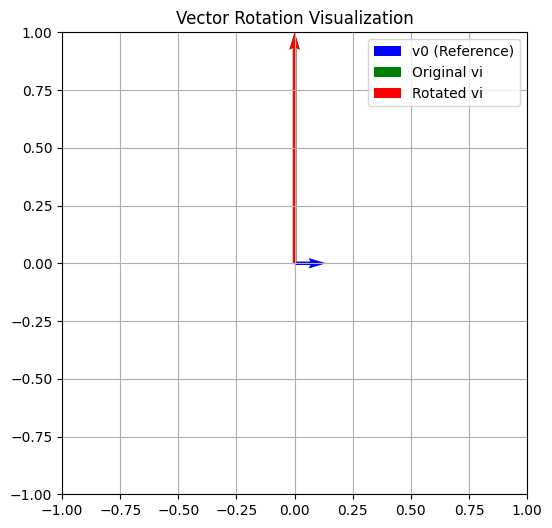

In [11]:
# Generate random MAX-2SAT instance
N = 200     # Number of variables
M = N * 1 # Number of clauses

instance = generate_max_2_sat(N, M)

# Get the exact solution using RC2 solver
sol, sol_nvc = rc2_solver(N, instance)
print("=" * 50)
print("EXACT SOLUTION (Using RC2 Solver)")
print("-" * 50)
print(f"Solution               : {sol}")
print(f"Violated Clauses (Exact): {sol_nvc}")
print("=" * 50)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")

# Function to display approximation ratios neatly
def display_results(method_name, NVC, M, sol_nvc):
    avg_ratio = (M - np.mean(NVC)) / (M - sol_nvc)
    best_ratio = (M - np.min(NVC)) / (M - sol_nvc)
    worst_ratio = (M - np.max(NVC)) / (M - sol_nvc)
    
    print(f"\n{method_name}")
    print("-" * len(method_name))
    print(f"Average Approximation Ratio : {avg_ratio:.4f}")
    print(f"Best Approximation Ratio    : {best_ratio:.4f}")
    print(f"Worst Approximation Ratio   : {worst_ratio:.4f}")
    print("=" * 50)

# Rounding using 0.87 Random Hyperplane
NVC = rounding_87(Y, N, instance, 1000)
display_results("0.87 Random Hyperplane Rounding", NVC, M, sol_nvc)

# Goemans-Williamson (G&W) Random Hyperplane Rounding
NVC = gw_rounding(Y, N, instance)
display_results("Goemans-Williamson (G&W) Rounding", NVC, M, sol_nvc)

# ROT (Rotation-Based Rounding)
NVC = rot_rounding(Y, N, instance)
display_results("ROT (Rotation-Based Rounding)", NVC, M, sol_nvc)

# SKEW (Skewed Hyperplane Rounding)
NVC = skew_rounding(Y, N, instance)
display_results("SKEW (Skewed Hyperplane Rounding)", NVC, M, sol_nvc)

# ROT + SKEW (Combined Rotation and Skewed Hyperplane Rounding)
NVC = rot_skew_rounding(Y, N, instance)
display_results("ROT + SKEW (Combined Rounding)", NVC, M, sol_nvc)

import numpy as np
import matplotlib.pyplot as plt


# Theoretical Check: Verify Rotation Correctness
def theoretical_check(Y):
    S = decompose_sdp(Y)
    v0 = S[:, 0]
    vi = S[:, 1]

    # Y_0i = (Y[0, 1] + Y[1, 0]) / 2
    vi_rot = rotate_vector(v0, vi)

    # Plotting the original and rotated vectors
    plt.figure(figsize=(6, 6))
    plt.quiver(0, 0, v0[0], v0[1], angles='xy', scale_units='xy', scale=1, color='blue', label='v0 (Reference)')
    plt.quiver(0, 0, vi[0], vi[1], angles='xy', scale_units='xy', scale=1, color='green', label='Original vi')
    plt.quiver(0, 0, vi_rot[0], vi_rot[1], angles='xy', scale_units='xy', scale=1, color='red', label='Rotated vi')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.grid()
    plt.legend()
    plt.title('Vector Rotation Visualization')
    plt.show()


# Theoretical Check
theoretical_check(Y)

# 

In [15]:
# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

Y = SDP_max_sat(N, instance)        # Solve SDP -> Y
S = decompose_sdp(Y)                # S = sqrt(Y)
check_decomposition_consistency(Y, S)


Y matches BOTH columns-based (Y = S^T S) AND rows-based (Y = S S^T) within tolerance.


In [4]:
import numpy as np

# Define test function for decompose_sdp using Singular Value Decomposition (SVD)
def decompose_sdp(Y):
    U, Sigma, _ = np.linalg.svd(Y)  # Perform Singular Value Decomposition
    return U @ np.diag(np.sqrt(np.maximum(Sigma, 0)))  # Compute factor matrix S

# Generate a random symmetric positive semidefinite matrix Y
N = 5  # Small test case
random_matrix = np.random.randn(N + 1, N + 1)
Y = random_matrix @ random_matrix.T  # Construct Y to be positive semidefinite

# Decompose Y
S = decompose_sdp(Y)

# Verify that Y ≈ S S^T (should be close)
Y_reconstructed = S @ S.T
error = np.linalg.norm(Y - Y_reconstructed)  # Compute reconstruction error

# Print Results
print("Original SDP Matrix Y:\n", Y)
print("\nDecomposed Factor Matrix S:\n", S)
print("\nReconstructed Y (S @ S.T):\n", Y_reconstructed)
print("\nReconstruction Error (should be close to 0):", error)


Original SDP Matrix Y:
 [[ 3.9645627  -1.64599768  0.18245197 -3.08758079 -2.87997688 -1.96318561]
 [-1.64599768 11.1261294   1.00385994 -1.48232346 -1.61167038  8.67020181]
 [ 0.18245197  1.00385994  4.64991823 -2.56906379 -0.76183853  2.05215138]
 [-3.08758079 -1.48232346 -2.56906379  9.3394737   2.6825793  -4.05057938]
 [-2.87997688 -1.61167038 -0.76183853  2.6825793   8.08178383  0.53816259]
 [-1.96318561  8.67020181  2.05215138 -4.05057938  0.53816259  9.16737429]]

Decomposed Factor Matrix S:
 [[-0.21541169 -1.68665219  0.12070344 -0.45523678  0.91988329  0.07327864]
 [ 2.98722563  0.93643008  1.05462602 -0.1270317   0.43360591 -0.09656077]
 [ 0.8265898  -0.58868641 -0.76934008  1.71983484  0.26521454 -0.00781258]
 [-1.63868378  2.12903332  1.31179458  0.56863588  0.26643801  0.07915358]
 [-0.5911838   1.99155725 -1.85182888 -0.3739323   0.44270392 -0.03004881]
 [ 2.89092548  0.68910057 -0.49590728 -0.14854663 -0.21377987  0.14619367]]

Reconstructed Y (S @ S.T):
 [[ 3.9645627  -

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def check_eigenvalues(Y):
    """
    Check if Y is positive semidefinite by verifying all eigenvalues are non-negative.
    """
    eigenvalues, _ = np.linalg.eigh(Y)
    print("Eigenvalues of Y:", eigenvalues)
    if np.any(eigenvalues < -1e-7):
        print("Warning: Y has negative eigenvalues, indicating a possible SDP issue!")
    else:
        print("Y is positive semidefinite.")

def check_vector_rotation(v0, vi, vi_rot):
    """
    Verify that the rotation transformation maintains norms and alters angles correctly.
    """
    norm_vi = np.linalg.norm(vi)
    norm_vi_rot = np.linalg.norm(vi_rot)
    angle_before = np.arccos(np.clip(np.dot(v0, vi) / norm_vi, -1, 1))
    angle_after = np.arccos(np.clip(np.dot(v0, vi_rot) / norm_vi_rot, -1, 1))

    # Expected transformed angle
    expected_angle = 0.58831458 * angle_before + 0.64667394

    print(f"Norm Before: {norm_vi:.6f}, Norm After: {norm_vi_rot:.6f}")
    print(f"Angle Before: {np.degrees(angle_before):.2f}°, Angle After: {np.degrees(angle_after):.2f}°")
    print(f"Expected Angle: {np.degrees(expected_angle):.2f}°")

    if not np.isclose(norm_vi_rot, 1, atol=1e-7):
        print("Warning: Rotated vector is not unit-norm!")
    if not np.isclose(angle_after, expected_angle, atol=1e-2):
        print("Warning: Rotation function is not transforming angles correctly!")

def check_hyperplane_separation(vectors, trials=100):
    """
    Verify that the hyperplane rounding is consistent with the input vectors.
    """
    N = vectors.shape[1]
    separations = np.zeros((N, trials))

    for t in range(trials):
        r = np.random.randn(vectors.shape[0])
        r /= np.linalg.norm(r)

        for i in range(N):  # Fixing indexing issue
            separations[i, t] = np.sign(np.dot(vectors[:, i], r))

    # Compute consistency correctly (fix for broadcasting error)
    ref_column = np.tile(separations[:, 0].reshape(-1, 1), (1, trials))
    consistency = np.mean(separations == ref_column, axis=1)

    print("Hyperplane Separation Consistency:", consistency)

    if np.any(consistency < 0.95):  # Adjust threshold if necessary
        print("Warning: Hyperplane separation varies significantly across trials!")

def compare_rot_vs_gw(Y, N, instance, trials=1000):
    """
    Compare the performance of ROT and GW rounding methods.
    """
    from src.Max2sat import violated_clauses

    def rounding(Y, method):
        S = decompose_sdp(Y)
        v0 = S[:, 0]

        if method == "GW":
            solutions = []
            for _ in range(trials):
                r = np.random.randn(S.shape[0])
                r /= np.linalg.norm(r)
                solution = np.array([1 if np.sign(np.dot(v0, r)) == np.sign(np.dot(S[:, i], r)) else -1 for i in range(1, N + 1)])
                solutions.append(solution)
            return solutions
        
        elif method == "ROT":
            solutions = []
            for _ in range(trials):
                r = np.random.randn(S.shape[0])
                r /= np.linalg.norm(r)
                solution = []
                for i in range(1, N + 1):
                    vi_rot = rotate_vector(v0, S[:, i])  # Apply ROT transformation
                    solution.append(1 if np.sign(np.dot(v0, r)) == np.sign(np.dot(vi_rot, r)) else -1)
                solutions.append(np.array(solution))
            return solutions

    # Run both rounding methods
    gw_solutions = rounding(Y, "GW")
    rot_solutions = rounding(Y, "ROT")

    # Compute average violated clauses
    gw_violations = [violated_clauses(instance, sol) for sol in gw_solutions]
    rot_violations = [violated_clauses(instance, sol) for sol in rot_solutions]

    avg_gw = np.mean(gw_violations)
    avg_rot = np.mean(rot_violations)

    print(f"GW Rounding -> Average Violations: {avg_gw:.2f}")
    print(f"ROT Rounding -> Average Violations: {avg_rot:.2f}")

    # Plot performance comparison
    plt.hist(gw_violations, bins=20, alpha=0.5, label="GW")
    plt.hist(rot_violations, bins=20, alpha=0.5, label="ROT")
    plt.xlabel("Number of Violated Clauses")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Comparison of GW vs ROT Rounding Performance")
    plt.show()

    if avg_rot > avg_gw:
        print("Warning: ROT rounding is performing worse than GW!")


In [37]:
# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)


# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")

check_eigenvalues(Y)


Eigenvalues of Y: [-1.10883565e-08 -1.08616061e-08 -1.07358959e-08 -1.06993160e-08
 -1.06624199e-08 -1.06459933e-08 -1.05994476e-08 -1.05008125e-08
 -1.04495821e-08 -1.04015567e-08 -1.02997595e-08 -1.02506446e-08
 -1.01542324e-08 -1.01379995e-08 -1.00386115e-08 -9.99831862e-09
 -9.79706364e-09 -9.65832807e-09 -9.46311126e-09 -9.24337794e-09
 -9.02949305e-09 -8.40266669e-09 -8.03323592e-09 -6.22554553e-09
 -6.01024197e-09 -4.51959928e-09 -4.10164860e-09 -1.71963588e-09
  4.35092944e-10  3.49105114e-09  5.17454320e-09  9.00915414e-09
  1.40848968e-08  2.19460227e-08  4.04561247e-08  5.17562418e-08
  7.00107552e-08  7.63952699e-08  1.25261103e-07  1.41909260e-07
  1.66985212e-07  2.25127635e-07  2.69314843e-07  3.75523477e-07
  4.86839505e-07  6.97006770e-07  1.15222944e-06  2.14041674e-05
  8.94544269e+00  1.70255643e+01  2.50289674e+01]
Y is positive semidefinite.


In [39]:
v0 = np.random.randn(10)
v0 /= np.linalg.norm(v0)  # Ensure unit norm

vi = np.random.randn(10)
vi /= np.linalg.norm(vi)

vi_rot = rotate_vector(v0, vi)
check_vector_rotation(v0, vi, vi_rot)


Norm Before: 1.000000, Norm After: 1.000000
Angle Before: 65.12°, Angle After: 75.36°
Expected Angle: 75.36°


In [44]:
# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)


# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")


S = decompose_sdp(Y)
check_hyperplane_separation(S)


Hyperplane Separation Consistency: [0.55 0.52 0.54 0.6  0.51 0.46 0.56 0.53 0.5  0.53 0.53 0.56 0.53 0.52
 0.53 0.52 0.56 0.45 0.54 0.56 0.51 0.49 0.49 0.53 0.5  0.58 0.45 0.46
 0.59 0.49 0.55 0.5  0.58 0.52 0.58 0.54 0.46 0.55 0.54 0.54 0.48 0.5
 0.49 0.54 0.56 0.57 0.46 0.59 0.45 0.46 0.52]


GW Rounding -> Average Violations: 9.75
ROT Rounding -> Average Violations: 12.69


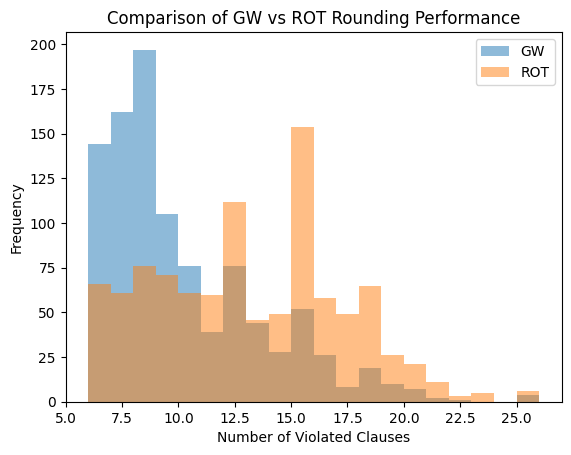

In [41]:
compare_rot_vs_gw(Y, N, instance)


In [67]:
def inspect_sdp_vectors(S, num_vectors=5):
    """
    Inspect the first few vectors in S to check for anomalies.
    """
    print("\n--- Inspecting SDP Vectors ---")
    for i in range(num_vectors):
        norm = np.linalg.norm(S[:, i])
        print(f"Vector {i}: Norm = {norm:.6f}, First 5 values: {S[:, i][:5]}")

    print("\nChecking if all vectors are unit-norm...")
    norms = np.linalg.norm(S, axis=0)
    print("Norms:", norms[:num_vectors])

    if not np.allclose(norms, 1, atol=1e-7):
        print("⚠️ Warning: Some vectors are not unit-norm. Ensure SDP decomposition is correct.")

# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")


S = decompose_sdp(Y)

S = decompose_sdp(Y)
inspect_sdp_vectors(S,50)



--- Inspecting SDP Vectors ---
Vector 0: Norm = 1.000000, First 5 values: [ 0.2230393  -0.05485096  0.15564269 -0.13803076  0.09941667]
Vector 1: Norm = 1.000000, First 5 values: [-0.05485096  0.3197172  -0.21340034  0.1323434   0.24132856]
Vector 2: Norm = 1.000000, First 5 values: [ 0.15564269 -0.21340034  0.26188396 -0.11060625 -0.0725217 ]
Vector 3: Norm = 1.000000, First 5 values: [-0.13803076  0.1323434  -0.11060625  0.395503    0.08343255]
Vector 4: Norm = 1.000000, First 5 values: [ 0.09941667  0.24132856 -0.0725217   0.08343255  0.29025168]
Vector 5: Norm = 1.000000, First 5 values: [ 0.11344617 -0.08857348  0.19567537  0.099734    0.04030059]
Vector 6: Norm = 1.000000, First 5 values: [-0.06099587 -0.13678623 -0.01469477  0.15973955 -0.13054717]
Vector 7: Norm = 1.000000, First 5 values: [ 0.12435408 -0.05869947  0.17552066  0.05535137  0.07414779]
Vector 8: Norm = 1.000000, First 5 values: [ 0.19385359 -0.08054458  0.1827481   0.01922615  0.0913046 ]
Vector 9: Norm = 1.0000

In [71]:
def verify_sdp_decomposition(Y, S):
    """
    Verify that S is the correct decomposition by checking Y ≈ S @ S.T
    """
    reconstructed_Y = S @ S.T
    error = np.linalg.norm(Y - reconstructed_Y)

    print(f"\nReconstruction Error ||Y - S*S.T||: {error:.8e}")

    if error > 1e-5:
        print("⚠️ Warning: S does not correctly reconstruct Y! Check decomposition method.")



# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")


S = decompose_sdp(Y)

verify_sdp_decomposition(Y, S)



Reconstruction Error ||Y - S*S.T||: 8.02592943e-08


In [75]:
def check_sdp_variance(S):
    """
    Check if SDP embeddings are diverse enough for reliable hyperplane separation.
    """
    variances = np.var(S, axis=1)
    print("\nVariance across SDP vectors (first 50 entries):", variances[:50])

    if np.mean(variances) < 1e-3:
        print("⚠️ Warning: SDP embeddings have very low variance! This may cause unstable hyperplane separation.")



# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")


S = decompose_sdp(Y)

check_sdp_variance(S)



Variance across SDP vectors (first 50 entries): [0.01844725 0.01924917 0.01928162 0.01908762 0.01931734 0.01818934
 0.01915095 0.01841077 0.01953333 0.01862771 0.01864837 0.01923761
 0.01832804 0.01852827 0.01947954 0.01945453 0.01885341 0.01921888
 0.01907757 0.01888973 0.01959199 0.01914523 0.0189098  0.01934504
 0.01923634 0.01797952 0.01940443 0.01818695 0.01943232 0.01892258
 0.01956875 0.01875    0.01886331 0.01821858 0.01884589 0.01820124
 0.01924162 0.01783924 0.01942307 0.01835354 0.01960428 0.01826823
 0.01903349 0.01955176 0.01940444 0.01960735 0.01795038 0.01854261
 0.01900064 0.0183368 ]


In [78]:
def check_hyperplane_separation(vectors, trials=100):
    """
    Verify that the hyperplane rounding is consistent with the input vectors.
    """
    N = vectors.shape[1]
    separations = np.zeros((N, trials))

    for t in range(trials):
        r = np.random.randn(vectors.shape[0])
        r /= np.linalg.norm(r)

        for i in range(N):
            separations[i, t] = np.sign(np.dot(vectors[:, i], r))

    # 🔹 Instead of always using `separations[:, 0]`, randomly pick a reference column
    ref_index = np.random.randint(0, trials)
    ref_column = np.tile(separations[:, ref_index].reshape(-1, 1), (1, trials))

    consistency = np.mean(separations == ref_column, axis=1)
    print("Hyperplane Separation Consistency:", consistency)

    if np.any(consistency < 0.95):  
        print("⚠️ Warning: Hyperplane separation varies significantly across trials!")
        
        
# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")


S = decompose_sdp(Y)        

check_hyperplane_separation(S)



Hyperplane Separation Consistency: [0.46 0.49 0.44 0.47 0.45 0.46 0.48 0.52 0.5  0.51 0.43 0.45 0.54 0.58
 0.52 0.52 0.48 0.47 0.49 0.47 0.57 0.43 0.46 0.47 0.53 0.53 0.42 0.55
 0.5  0.45 0.56 0.45 0.45 0.5  0.44 0.47 0.53 0.48 0.54 0.47 0.5  0.48
 0.54 0.52 0.55 0.51 0.48 0.56 0.51 0.5  0.5 ]
⚠️ Warning: Hyperplane separation varies significantly across trials!


In [83]:
def check_vector_diversity(S, threshold=0.99):
    """
    Checks if the SDP vectors are too similar (i.e., nearly collinear).
    """
    N = S.shape[1]
    cosine_similarities = np.zeros((N, N))

    for i in range(N):
        for j in range(i + 1, N):
            cosine_similarities[i, j] = np.dot(S[:, i], S[:, j]) / (np.linalg.norm(S[:, i]) * np.linalg.norm(S[:, j]))

    # Check for nearly collinear vectors
    high_sim_pairs = np.where(np.abs(cosine_similarities) > threshold)
    
    print(f"\nChecking vector similarity (threshold = {threshold}):")
    print(f"Number of nearly collinear pairs: {len(high_sim_pairs[0])}")

    if len(high_sim_pairs[0]) > 0:
        print("⚠️ Warning: Some vectors are nearly identical, which may cause unstable hyperplane separation!")
        
# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")


S = decompose_sdp(Y)        


check_vector_diversity(S)



Checking vector similarity (threshold = 0.99):
Number of nearly collinear pairs: 4
⚠️ Warning: Some vectors are nearly identical, which may cause unstable hyperplane separation!


In [87]:
def debug_hyperplane_separation(S, trials=10):
    """
    Print hyperplane separation decisions for the first few trials.
    """
    N = S.shape[1]
    separations = np.zeros((N, trials))

    for t in range(trials):
        r = np.random.randn(S.shape[0])
        r /= np.linalg.norm(r)

        for i in range(N):
            separations[i, t] = np.sign(np.dot(S[:, i], r))

    print("\n🔹 First Few Trials of Hyperplane Separation:")
    for i in range(min(N, 5)):  # Print first 5 vectors only
        print(f"Vector {i}: {separations[i, :]}")

    flip_counts = np.sum(separations[:, 1:] != separations[:, :-1], axis=1)
    print(f"\nFlips per vector across trials: {flip_counts}")

    if np.any(flip_counts > trials // 2):
        print("⚠️ Warning: Some vectors frequently flip sides, suggesting instability in rounding!")
        
# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")


S = decompose_sdp(Y)        


debug_hyperplane_separation(S)



🔹 First Few Trials of Hyperplane Separation:
Vector 0: [-1.  1. -1. -1. -1. -1.  1. -1.  1.  1.]
Vector 1: [-1.  1. -1. -1. -1. -1. -1. -1.  1. -1.]
Vector 2: [ 1. -1.  1.  1.  1.  1. -1.  1. -1.  1.]
Vector 3: [-1.  1.  1.  1.  1.  1. -1. -1. -1.  1.]
Vector 4: [ 1. -1.  1.  1. -1.  1. -1.  1. -1. -1.]

Flips per vector across trials: [5 4 6 3 7 4 5 4 5 5 4 5 5 6 6 5 2 5 2 5 5 5 5 5 5 4 5 7 5 6 5 7 5 5 4 2 6
 2 5 5 5 5 4 6 6 3 4 5 3 4 4]
⚠️ Warning: Some vectors frequently flip sides, suggesting instability in rounding!


In [91]:
def check_rank_of_Y(Y, tol=1e-5):
    """
    Checks the numerical rank of Y to see if the SDP solution is collapsing into a low-rank subspace.
    """
    singular_values = np.linalg.svd(Y, compute_uv=False)
    rank = np.sum(singular_values > tol)

    print(f"\nNumerical Rank of Y: {rank} / {Y.shape[0]} (Singular Values: {singular_values[:10]})")

    if rank < Y.shape[0] * 0.9:
        print("⚠️ Warning: Y has low rank! This means the SDP solution is not generating enough independent vectors.")


# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")


S = decompose_sdp(Y)        

check_rank_of_Y(Y)



Numerical Rank of Y: 4 / 51 (Singular Values: [2.43591343e+01 2.19065883e+01 3.67051605e+00 1.06375855e+00
 1.11651805e-06 4.69702614e-07 2.62128206e-07 2.03680254e-07
 1.11386968e-07 7.29430324e-08])
⚠️ Warning: Y has low rank! This means the SDP solution is not generating enough independent vectors.


In [94]:
def check_condition_number(Y):
    """
    Checks the condition number of Y to see if the SDP solution is poorly conditioned.
    """
    singular_values = np.linalg.svd(Y, compute_uv=False)
    cond_number = singular_values.max() / singular_values.min()

    print(f"\nCondition Number of Y: {cond_number:.6e}")

    if cond_number > 1e6:
        print("⚠️ Warning: Y is ill-conditioned! This can lead to poor vector embeddings.")

# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")


check_condition_number(Y)



Condition Number of Y: 2.588354e+11
⚠️ Warning: Y is ill-conditioned! This can lead to poor vector embeddings.


In [96]:
def check_singular_values_S(S):
    """
    Checks if the SDP decomposition S is generating independent vectors.
    """
    singular_values = np.linalg.svd(S, compute_uv=False)
    print(f"\nSingular Values of S (first 10): {singular_values[:10]}")

    if np.any(singular_values < 1e-5):
        print("⚠️ Warning: S has near-zero singular values! The SDP vectors are not independent.")

# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")

check_singular_values_S(S)



Singular Values of S (first 10): [4.93549737e+00 4.68044745e+00 1.91585909e+00 1.03138671e+00
 1.05665418e-03 6.85348535e-04 5.11984576e-04 4.51309488e-04
 3.33746863e-04 2.70079678e-04]
⚠️ Warning: S has near-zero singular values! The SDP vectors are not independent.


In [100]:
# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")

def regularize_Y(Y, epsilon=1e-4):
    """
    Adds a small identity matrix to Y to prevent it from being singular.
    """
    print("\n🔹 Regularizing Y to improve rank and conditioning...")
    Y_reg = Y + epsilon * np.eye(Y.shape[0])
    return Y_reg

Y = regularize_Y(Y)

from sklearn.utils.extmath import randomized_svd

def decompose_sdp_fixed(Y):
    """
    Decomposes Y using Randomized SVD for better numerical stability.
    """
    print("\n🔹 Using Randomized SVD for decomposition...")
    U, Sigma, VT = randomized_svd(Y, n_components=Y.shape[0], random_state=42)
    S = U @ np.diag(np.sqrt(Sigma))
    return S

S = decompose_sdp_fixed(Y)

def decorrelate_vectors(S, noise_level=0.01):
    """
    Adds small noise to SDP vectors to prevent them from being nearly collinear.
    """
    print("\n🔹 Adding noise to break collinearity...")
    noise = noise_level * np.random.randn(*S.shape)
    S += noise
    S /= np.linalg.norm(S, axis=0)  # Re-normalize each vector
    return S

S = decorrelate_vectors(S)



🔹 Regularizing Y to improve rank and conditioning...

🔹 Using Randomized SVD for decomposition...

🔹 Adding noise to break collinearity...


In [101]:
check_rank_of_Y(Y)



Numerical Rank of Y: 51 / 51 (Singular Values: [3.27946984e+01 1.33531603e+01 4.85244116e+00 1.00092987e-04
 1.00006958e-04 1.00002424e-04 1.00002267e-04 1.00001742e-04
 1.00001552e-04 1.00000920e-04])


In [102]:
check_condition_number(Y)



Condition Number of Y: 3.279472e+05


In [103]:
check_singular_values_S(S)



Singular Values of S (first 10): [1.87840053 1.83801311 1.77834162 1.71930223 1.645353   1.60333325
 1.55030079 1.51180463 1.47900114 1.41756127]


In [104]:
check_hyperplane_separation(S)


Hyperplane Separation Consistency: [0.46 0.5  0.44 0.53 0.53 0.5  0.56 0.5  0.46 0.45 0.54 0.48 0.43 0.45
 0.46 0.41 0.51 0.47 0.46 0.53 0.52 0.51 0.42 0.58 0.57 0.6  0.53 0.64
 0.47 0.55 0.43 0.47 0.54 0.51 0.51 0.61 0.56 0.43 0.5  0.45 0.51 0.46
 0.53 0.51 0.56 0.52 0.5  0.54 0.56 0.56 0.5 ]
⚠️ Warning: Hyperplane separation varies significantly across trials!


In [106]:
def stable_hyperplane_rounding(S, bias=0.1):
    """
    Introduces a bias to the hyperplane selection to reduce instability.
    """
    print("\n🔹 Using bias in hyperplane selection to stabilize rounding...")
    
    r = np.random.randn(S.shape[0])  # Generate random hyperplane
    noise = bias * S[:, 0]  # Introduce small alignment to reference vector
    r = (1 - bias) * r + noise
    r /= np.linalg.norm(r)  # Normalize the hyperplane

    return np.sign(np.dot(S.T, r))  # Return the final decision

def check_stable_hyperplane_separation(S, trials=100, bias=0.1):
    """
    Verify that hyperplane rounding is consistent with stable selection.
    """
    N = S.shape[1]
    separations = np.zeros((N, trials))

    for t in range(trials):
        separations[:, t] = stable_hyperplane_rounding(S, bias=bias)  # 🔹 Use stable rounding!

    # Compute consistency correctly
    ref_index = np.random.randint(0, trials)
    ref_column = np.tile(separations[:, ref_index].reshape(-1, 1), (1, trials))

    consistency = np.mean(separations == ref_column, axis=1)
    print("\n🔹 Stable Hyperplane Separation Consistency:", consistency)

    if np.any(consistency < 0.95):  
        print("⚠️ Warning: Hyperplane separation still varies significantly! Consider increasing bias.")




In [110]:
# Generate random MAX-2SAT instance
N = 50     # Number of variables
M = N * 3 # Number of clauses

instance = generate_max_2_sat(N, M)

# Solve SDP relaxation of the instance
Y = SDP_max_sat(N, instance, "Mosek")

# Y = regularize_Y(Y)

# S = decompose_sdp_fixed(Y)
S = decompose_sdp(Y)

# S = decorrelate_vectors(S)


check_stable_hyperplane_separation(S, trials=100, bias=0.1)





🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize rounding...

🔹 Using bias in hyperplane selection to stabilize roun